In [3]:
source("../../R/gen_data.R")
source("../../R/display.R")
source("../../R/metrics.R")
source("../../R/JGL.R")
source("../../R/admm.iters.R")
source("../../R/gete.R")
source("../../R/SSJGL.R")
source("../../R/eval.R")
library(JGL)
library(GGMselect)
library(network)
library(intergraph) #convert between network and igraph
library(BDgraph)
library(tmvtnorm)
library(matlab)
library(ggplot2)
library(viridis)
library(latex2exp)

Loading required package: igraph

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

Loading required package: mvtnorm

‘network’ 1.17.1 (2021-06-12), part of the Statnet Project
* ‘news(package="network")’ for changes since last version
* ‘citation("network")’ for citation information
* ‘https://statnet.org’ for help, support, and other information


Attaching package: ‘network’

The following objects are masked from ‘package:igraph’:

    %c%, %s%, add.edges, add.vertices, delete.edges, delete.vertices,
    get.edge.attribute, get.edges, get.vertex.attribute, is.bipartite,
    is.directed, list.edge.attributes, list.vertex.attributes,
    set.edge.attribute, set.vertex.attribute


Attaching package: ‘BDgraph’

The following object is masked from ‘package:mvtnorm’:

    rmvnorm

The following object is masked from ‘package:igraph’:

    compare

Loading required p

In [15]:
path <- "../../figures/simple_example_block/"
ID <- "block_003"

[1] "Base Graph"


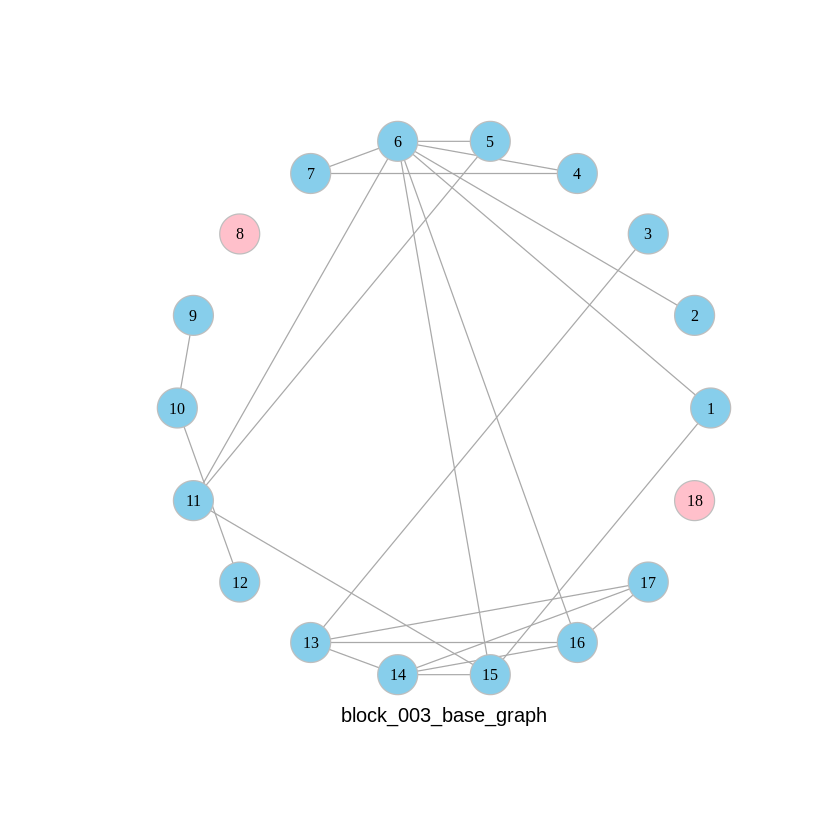

In [6]:
##############################
#     generate base graph    #
#                            #
##############################
set.seed(1)
print("Base Graph")
p=18
# simulate grap
eta=0.15


base_Gr <- gen_baseGraph(p,eta)

# plot the graph
base_gV <- network(base_Gr$G, directed=FALSE)
#plot_network(base_gV)


#convert network to igraph
ibase_gV <- asIgraph(base_gV)

plot_igraph(ibase_gV, paste(ID,"_base_graph",sep=""),path=path)


[1] "Graph 1"
[1] "Graph 2"
[1] "Graph 3"


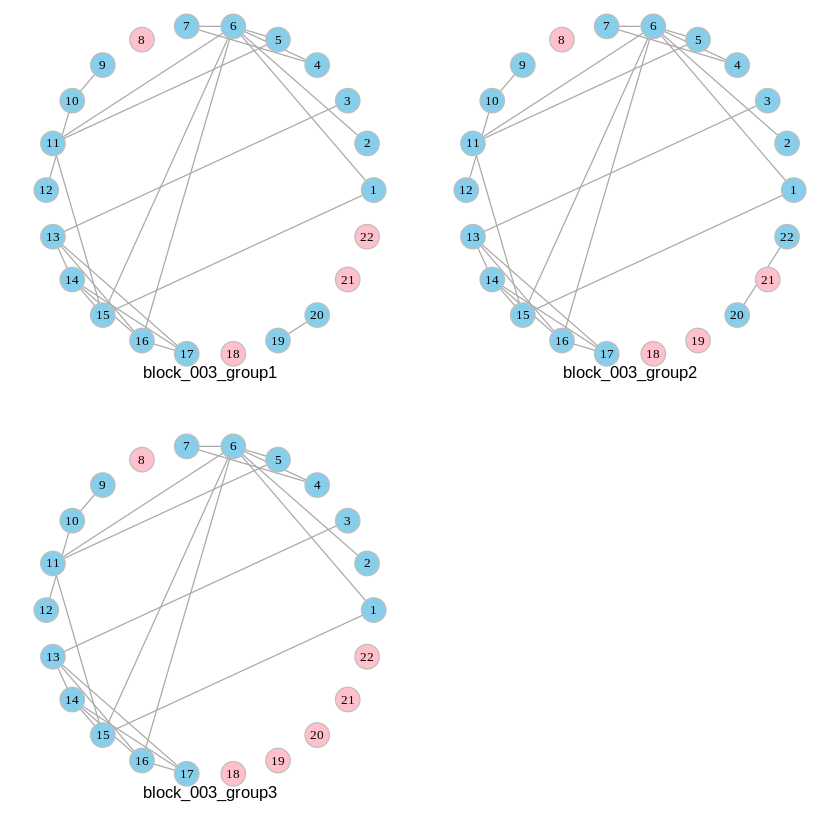

In [8]:
##############################
#       generate groups      #
#                            #
##############################
set.seed(10)
p=4
n=40
eta=0.8
par(mfrow=c(2,2), mar = c(2., 0., 0., 0.)) 
data <- list()
graph <- list()
for (i in 1:3){
    print(paste("Graph",i))
    
    #simulate graph and data
    group_i <- gen_groupGraph_mask(n,p,eta,base_Gr)
    
    #constuct network
    gVi <- network(group_i$Gr$G, directed=FALSE)
    
    #convert network to igraph
    i_gVi <- asIgraph(gVi)
    
    plot_igraph(i_gVi,title=paste(ID,"_group",i,sep=""),line_placement=-19,path=path)
    graph[i] <- list(list("igraph"=i_gVi, "ggm"=group_i$Gr))
    data[i] <-list(group_i$X)
}


In [9]:
print("##################################################")
print("#             Fused Graphical Lasso              #")
print("##################################################")
fgl.results=JGL(Y=data,penalty="fused",lambda1=.1,lambda2=.2, return.whole.theta=TRUE)
print(paste("Average entropy loss:", entropy_loss(fgl.results, graph, p, 3)))
print(paste("Average frobenious loss:", frobenious_loss(fgl.results, graph, 3)))
print(paste("Average false positive rate:", avg_fprfnr(fgl.results, graph, 3)[1]))
print(paste("Average false negative rate:", avg_fprfnr(fgl.results, graph, 3)[2]))

#show_result(fgl.results, graph, 4)

[1] "##################################################"
[1] "#             Fused Graphical Lasso              #"
[1] "##################################################"
[1] "Average entropy loss: 24.373263791937"
[1] "Average frobenious loss: 0.807796628580452"
[1] "Average false positive rate: 0.201160675073719"
[1] "Average false negative rate: 0.588274044795784"


In [10]:
#########################################
#      test group graphical lasso       #
#                                       #
#########################################

print("##################################################")
print("#            Group Graphical Lasso               #")
print("##################################################")
ggl.results=JGL(Y=data,penalty="group",lambda1=.1,lambda2=.1, return.whole.theta=TRUE)
print(paste("Average entropy loss:", entropy_loss(ggl.results, graph, p, 3)))
print(paste("Average frobenious loss:", frobenious_loss(ggl.results, graph, 3)))
print(paste("Average false positive rate:", avg_fprfnr(ggl.results, graph, 3)[1]))
print(paste("Average false negative rate:", avg_fprfnr(ggl.results, graph, 3)[2]))
#show_result(fgl.results, graph, 4, method="group")

[1] "##################################################"
[1] "#            Group Graphical Lasso               #"
[1] "##################################################"
[1] "Average entropy loss: 26.1538102313809"
[1] "Average frobenious loss: 0.863238517411806"
[1] "Average false positive rate: 0.247455925716795"
[1] "Average false negative rate: 0.529644268774703"


In [11]:
#########################################
#          test graphical lasso         #
#                                       #
#########################################

print("##################################################")
print("#                Graphical Lasso                 #")
print("##################################################")
gl.results=JGL(Y=data,penalty="fused",lambda1=.1,lambda2=.0, return.whole.theta=TRUE)
print(paste("Average entropy loss:", entropy_loss(gl.results, graph, p, 2)))
print(paste("Average frobenious loss:", frobenious_loss(gl.results, graph, 2)))
print(paste("Average false positive rate:", avg_fprfnr(gl.results, graph, 2)[1]))
print(paste("Average false negative rate:", avg_fprfnr(gl.results, graph, 2)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
#show_result(fgl.results, graph, 4, method="gl")

[1] "##################################################"
[1] "#                Graphical Lasso                 #"
[1] "##################################################"
[1] "Average entropy loss: 24.9060816634071"
[1] "Average frobenious loss: 0.797820666133834"
[1] "Average false positive rate: 0.295652173913043"
[1] "Average false negative rate: 0.565217391304348"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"


In [12]:
##############################
#     Different lambda 1     #
#                            #
##############################
lambda.eff <- seq(0.01, 0.5, len = 50)

el_vec <- matrix(NA,3, length(lambda.eff))
fr_vec <- matrix(NA,3, length(lambda.eff))
fpr_vec <- matrix(NA,3, length(lambda.eff))
fnr_vec <- matrix(NA,3, length(lambda.eff))
#sse_vec <- matrix(NA,3, length(lambda.eff))
for(i in 1:length(lambda.eff)){
	fit <-list()
    fit[1] <- list(JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=.2, return.whole.theta=TRUE))
    fit[2] <- list(JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=.1, return.whole.theta=TRUE)) 
    fit[3] <- list(JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=.0, return.whole.theta=TRUE)) 

    for(j in 1:3){
        fpr_vec[j,i] <-avg_fprfnr(fit[[j]], graph, 3)[1]
        fnr_vec[j,i] <- avg_fprfnr(fit[[j]], graph, 3)[2]
        el_vec[j,i] <- entropy_loss(fit[[j]], graph, p, 3)
        fr_vec[j,i] <- frobenious_loss(fit[[j]], graph, 3)
        #sse_vec[j,i] <- sum_of_squared_error(fit[[j]], graph, 4)
    }

}
#sse_vec <- sse_vec / 4

png 
  5

png 
  2

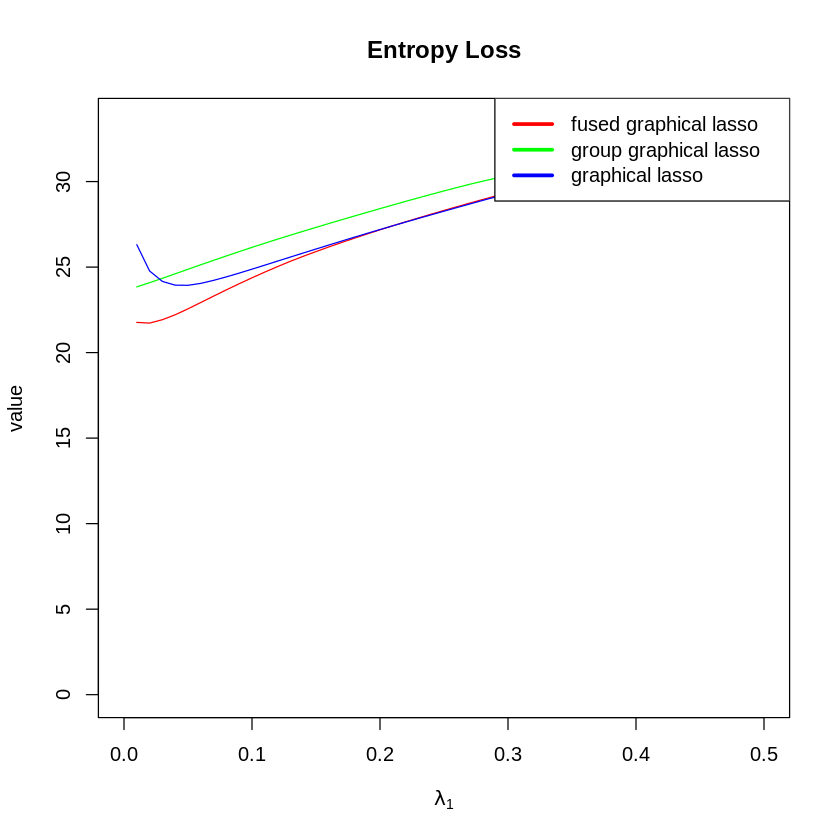

png 
  5

png 
  2

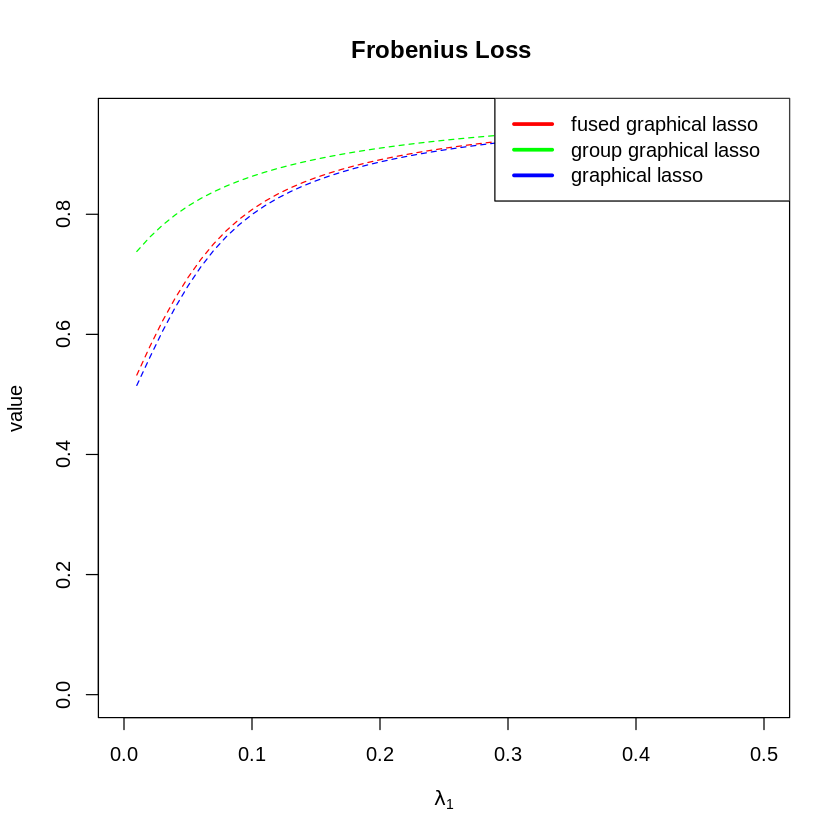

png 
  5

png 
  2

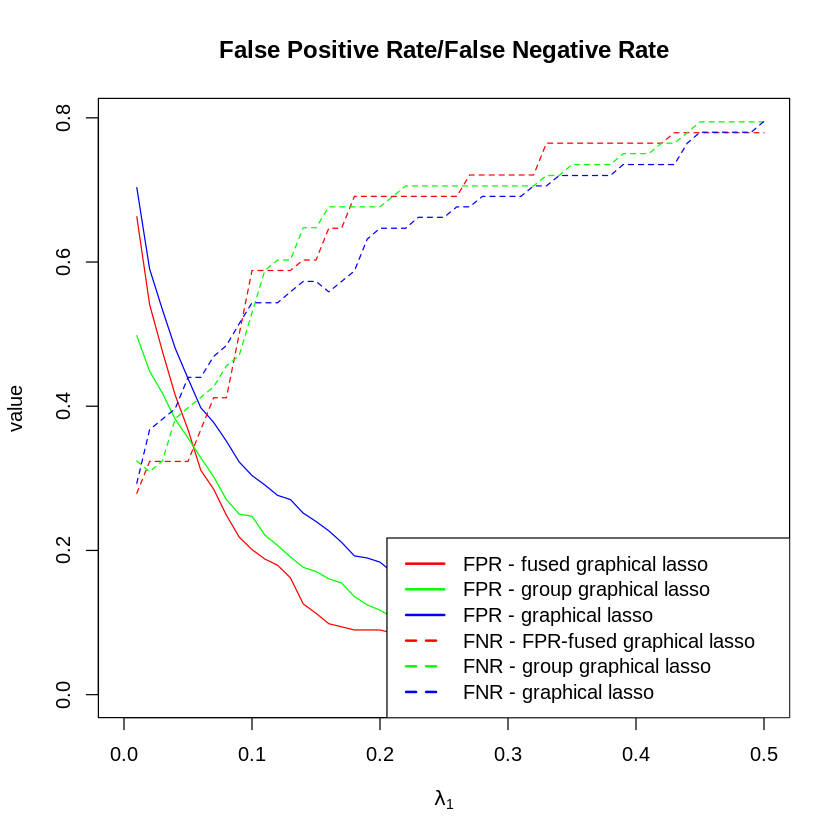

In [16]:
##########################
#    Entropy Loss        #
#                        #
##########################

cl <- rainbow(3)
plot(0,0,xlim = c(0.0,0.5),ylim = c(0,max(el_vec)),type = "n",xlab=TeX('$\\lambda_1$'),ylab="value",main="Entropy Loss")
lines(lambda.eff, el_vec[1,], col=cl[1], type="l") 
lines(lambda.eff, el_vec[2,], col=cl[2], type="l") 
lines(lambda.eff, el_vec[3,], col=cl[3], type="l") 


legend_txt <- c("fused graphical lasso","group graphical lasso","graphical lasso")
legend("topright", legend = legend_txt, col = cl, cex = 1, lwd = 3)
dev.copy(png, file=paste(path,ID,"_entropy_loss",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

############################
#    Frobenius Loss        #
#                          #
############################

cl <- rainbow(3)
plot(0,0,xlim = c(0.0,0.5),ylim = c(0,max(fr_vec)),type = "n",xlab=TeX('$\\lambda_1$'),ylab="value",main="Frobenius Loss ")
lines(lambda.eff, fr_vec[1,], col=cl[1], type="l",lty=2) 
lines(lambda.eff, fr_vec[2,], col=cl[2], type="l",lty=2) 
lines(lambda.eff, fr_vec[3,], col=cl[3], type="l",lty=2) 
legend_txt <- c("fused graphical lasso","group graphical lasso","graphical lasso")
legend("topright", legend = legend_txt, col = cl, cex = 1, lwd = 3)
dev.copy(png, file=paste(path,ID,"_frobenius_loss",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

##########################
#          FPR,FNR       #
#                        #
##########################



cl <- rainbow(3)
plot(0,0,xlim = c(0.0,0.5),ylim = c(0,max(fnr_vec)),type = "n",xlab=TeX('$\\lambda_1$'),ylab="value",main="False Positive Rate/False Negative Rate")
lines(lambda.eff, fpr_vec[1,], col=cl[1], type="l") 
lines(lambda.eff, fpr_vec[2,], col=cl[2], type="l") 
lines(lambda.eff, fpr_vec[3,], col=cl[3], type="l") 
lines(lambda.eff, fnr_vec[1,], col=cl[1], type="l",lty=2) 
lines(lambda.eff, fnr_vec[2,], col=cl[2], type="l",lty=2) 
lines(lambda.eff, fnr_vec[3,], col=cl[3], type="l",lty=2) 
legend_txt <- c("FPR - fused graphical lasso","FPR - group graphical lasso","FPR - graphical lasso",
"FNR - FPR-fused graphical lasso","FNR - group graphical lasso","FNR - graphical lasso")
legend("bottomright", legend = legend_txt, col = cl, cex = 1, lwd = 2,lty=c(1,1,1,2,2,2))
dev.copy(png, file=paste(path,ID,"_fpr_fnr",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

###  Akaike Information Criterion (AIC)
$vAIC(\lambda_1,\lambda_2)=\sum_{k=1}^K n_k tr(S^{(k)}\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2})-n_k\log\det\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2}+2E_k$

$S^{(k)}$ is the sampled covariance of group $k$

$\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2}$ is the estimated inverse covariance matrix under parameters $\lambda_1,\lambda_2$

$E_k$ is the number of nonzero elements in $\hat{\Theta}^{(k)}_{\lambda_1,\lambda_2}$

perform grid search tuning the parameters

In [17]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
###########################################
AIC <- function(X, est_graph){
    num <- length(X)
    AIC_acc <- 0.
    for(i in 1:num){
        
        data_num <- dim(X[[i]])[1]
        sample_cov <- cov(X[[i]], X[[i]])
        tr_sum <- sum(diag(sample_cov %*% est_graph$theta[[i]]))

        log_det <- determinant(est_graph$theta[[i]], logarithm = TRUE)$modulus[1][1]

        E <- sum(sum(est_graph$theta[[i]] != 0.))
        AIC_acc <- AIC_acc + data_num*(tr_sum - log_det) + 2*E
    }
    return(AIC_acc)
}

In [18]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
#       #perform 2D grid search           #
###########################################
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
aic_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))
for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        aic_vec[i,j] <- vAIC(data, fit00)        
    }

}

[1] "lambda_1 0.06"
[1] "lambda_2 0.01"


png 
  5

png 
  2

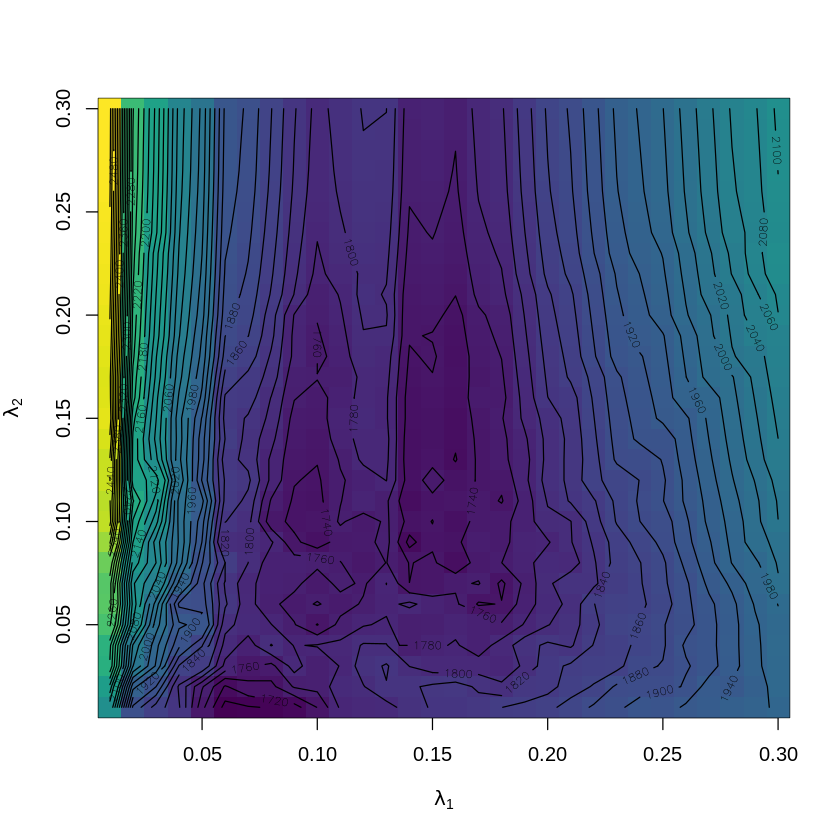

In [19]:

image(x=seq(0.01,0.3,0.01),y=seq(0.01,0.3,0.01),z=aic_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=seq(0.01,0.3,0.01),y=seq(0.01,0.3,0.01),z=aic_vec, add = TRUE,nlevels = 50)
i_idx <- which(aic_vec == min(aic_vec), arr.ind = TRUE)[1,1]
j_idx <- which(aic_vec == min(aic_vec), arr.ind = TRUE)[1,2]


lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))

dev.copy(png, file=paste(path,ID,"_AIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

In [20]:
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
bic_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))
for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="fused",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        bic_vec[i,j] <- vBIC(data, fit00)        
    }

}

[1] "lambda_1 0.18"
[1] "lambda_2 0.11"


png 
  5

png 
  2

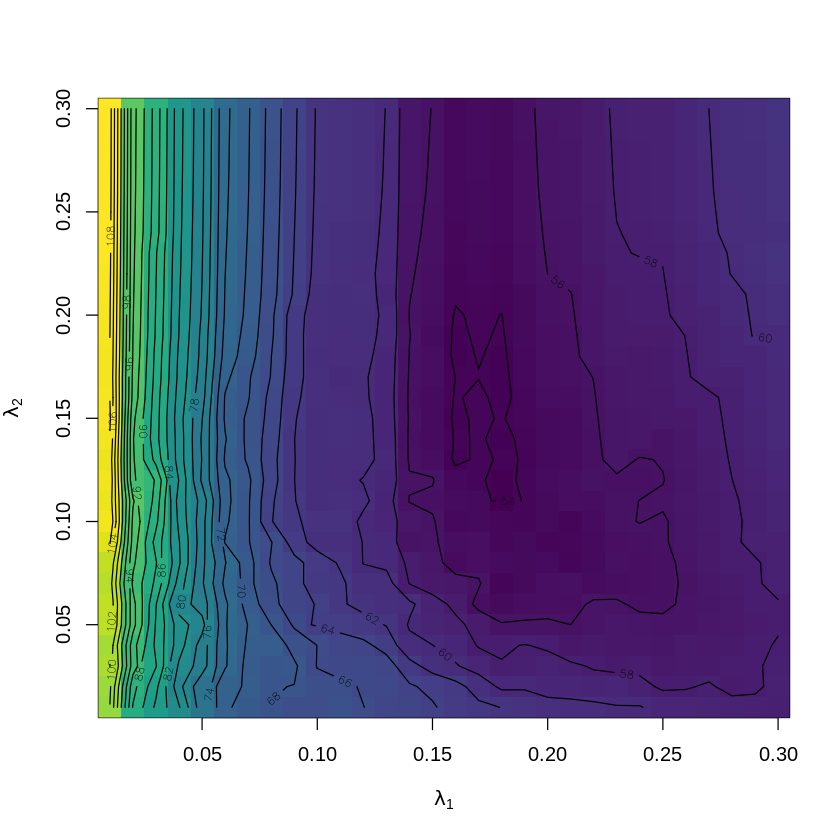

In [21]:

image(x=seq(0.01,0.3,0.01),y=seq(0.01,0.3,0.01),z=bic_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=seq(0.01,0.3,0.01),y=seq(0.01,0.3,0.01),z=bic_vec, add = TRUE,nlevels = 30)
i_idx <- which(bic_vec == min(bic_vec), arr.ind = TRUE)[1,1]
j_idx <- which(bic_vec == min(bic_vec), arr.ind = TRUE)[1,2]


lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))
dev.copy(png, file=paste(path,ID,"_BIC",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

In [22]:
print("##################################################")
print("#    Fused Graphical Lasso (tuned parameters)    #")
print("##################################################")
print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))
fgl_t.results=JGL(Y=data,penalty="fused",lambda1=lam_1,lambda2=lam_2, return.whole.theta=TRUE) 
print(paste("Average entropy loss:", entropy_loss(fgl_t.results, graph, p, 3)))
print(paste("Average frobenious loss:", frobenious_loss(fgl_t.results, graph, 3)))
print(paste("Average false positive rate:", avg_fprfnr(fgl_t.results, graph, 3)[1]))
print(paste("Average false negative rate:", avg_fprfnr(fgl_t.results, graph, 3)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
#show_result(fgl_t.results, graph, 2, method="fgl_t_block")

[1] "##################################################"
[1] "#    Fused Graphical Lasso (tuned parameters)    #"
[1] "##################################################"
[1] "lambda_1 0.18"
[1] "lambda_2 0.11"
[1] "Average entropy loss: 26.6082642228394"
[1] "Average frobenious loss: 0.880321417867204"
[1] "Average false positive rate: 0.0940711462450593"
[1] "Average false negative rate: 0.705533596837945"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"


In [23]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
#       #perform 2D grid search           #
###########################################
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
aic_g_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))
for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        aic_g_vec[i,j] <- vAIC(data, fit00)        
    }

}

[1] "lambda_1 0.06"
[1] "lambda_2 0.01"


png 
  5

png 
  2

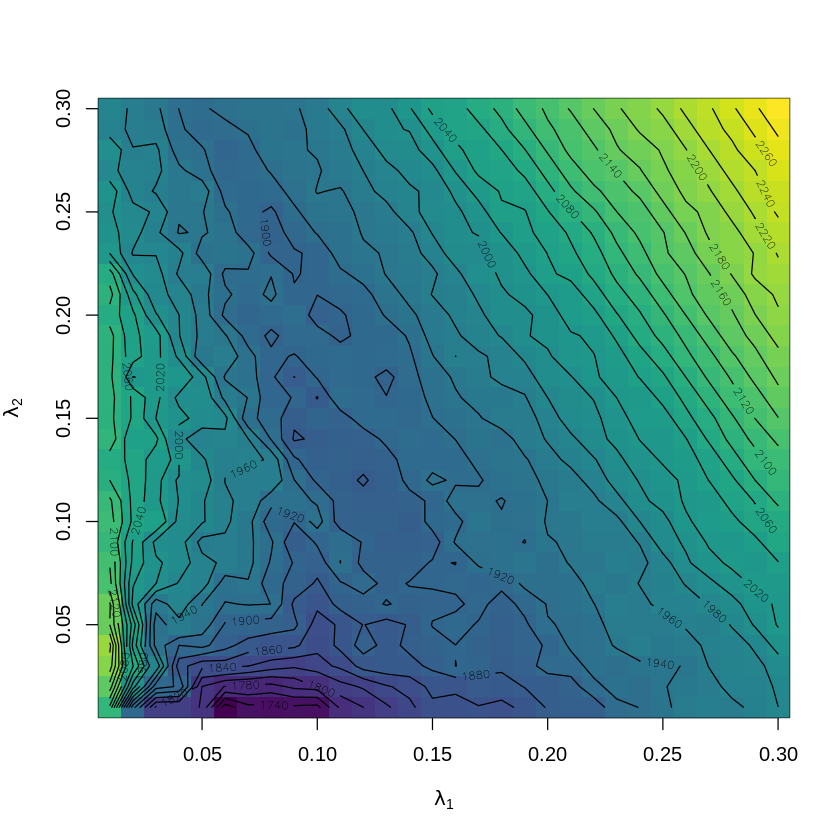

In [24]:
###########################################
#         group graphical lasso           #
###########################################

lambda.eff <- seq(0.01, 0.3, len = interval_l)
image(x=lambda.eff,y=lambda.eff,z=aic_g_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=lambda.eff,y=lambda.eff,z=aic_g_vec, add = TRUE,nlevels = 30)
i_idx <- which(aic_g_vec == min(aic_g_vec), arr.ind = TRUE)[1,1]
j_idx <- which(aic_g_vec == min(aic_g_vec), arr.ind = TRUE)[1,2]

lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))
dev.copy(png, file=paste(path,ID,"_AIC_GGL",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

In [25]:
interval_l = 30
lambda.eff <- seq(0.01, 0.3, len = interval_l)
bic_g_vec <- matrix(NA, length(lambda.eff),length(lambda.eff))
for(i in 1:length(lambda.eff)){
    for(j in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=lambda.eff[j], return.whole.theta=TRUE) 
        bic_g_vec[i,j] <- vBIC(data, fit00)        
    }

}

[1] "lambda_1 0.27"
[1] "lambda_2 0.05"


png 
  5

png 
  2

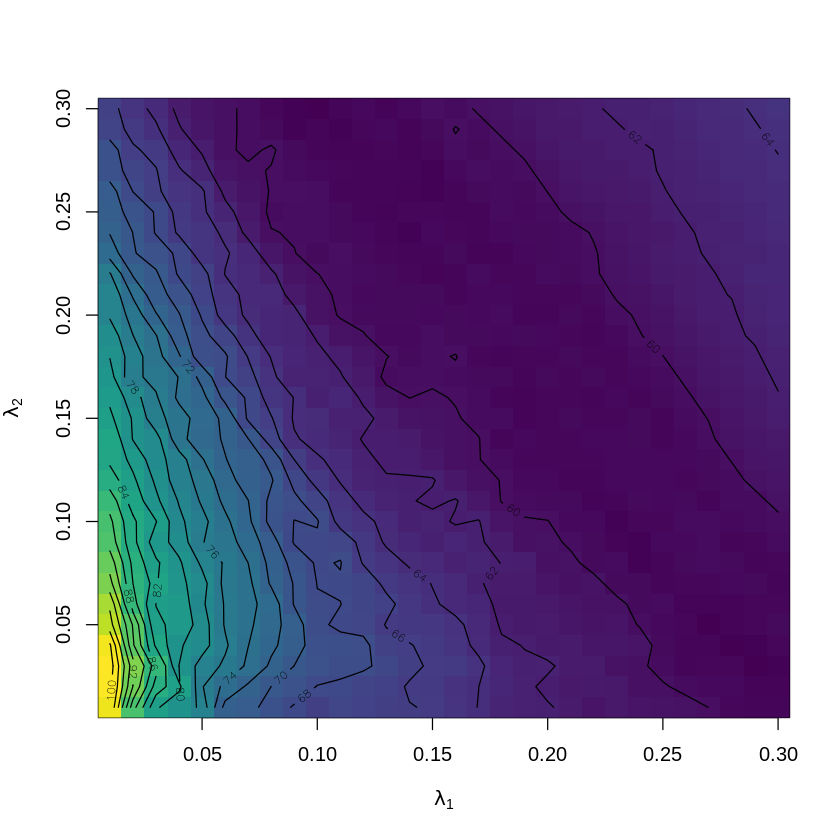

In [27]:
###########################################
#         group graphical lasso           #
###########################################

lambda.eff <- seq(0.01, 0.3, len = interval_l)
image(x=lambda.eff,y=lambda.eff,z=bic_g_vec, col=viridis(256),
      ylab=TeX('$\\lambda_2$'),xlab=TeX('$\\lambda_1$'))
contour(x=lambda.eff,y=lambda.eff,z=bic_g_vec, add = TRUE,nlevels = 30)
i_idx <- which(bic_g_vec == min(bic_g_vec), arr.ind = TRUE)[1,1]
j_idx <- which(bic_g_vec == min(bic_g_vec), arr.ind = TRUE)[1,2]

lam_1 <- lambda.eff[i_idx]
lam_2 <- lambda.eff[j_idx]

print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))
dev.copy(png, file=paste(path,ID,"_BIC_GGL",".png",sep=""),width = 480, height = 480, units = "px", pointsize = 12)
dev.off()

[1] "##################################################"
[1] "#    Group Graphical Lasso (tuned parameters)    #"
[1] "##################################################"
[1] "lambda_1 0.27"
[1] "lambda_2 0.05"
[1] "Average entropy loss: 29.269999680718"
[1] "Average frobenious loss: 0.92095604504766"
[1] "Average false positive rate: 0.0839136708701926"
[1] "Average false negative rate: 0.705533596837945"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"
[1] "visualize estimated graph 1"
[1] "False Negative Rate: 0.695652173913043"
[1] "False Positive Rate: 0.0608695652173913"
[1] "Sensitivity 0.0132325141776938"
[1] "visualize estimated graph 2"
[1] "False Negative Rate: 0.739130434782609"
[1] "False Positive Rate: 0.1"
[1] "Sensitivity 0.0113421550094518"


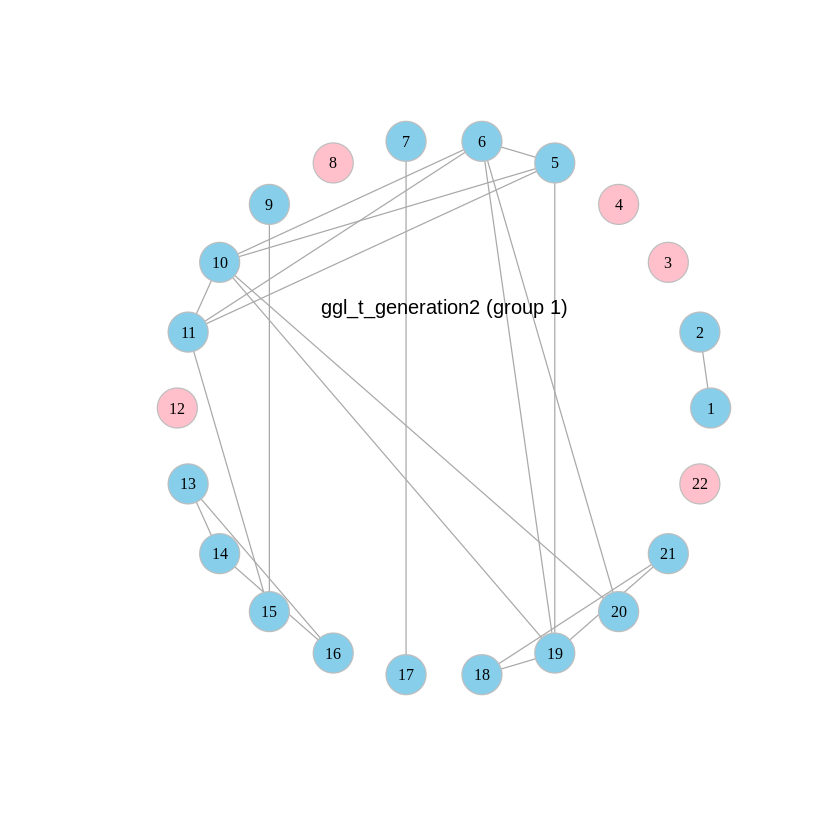

[1] "visualize estimated graph 3"
[1] "False Negative Rate: 0.681818181818182"
[1] "False Positive Rate: 0.0995670995670996"
[1] "Sensitivity 0.0144628099173554"


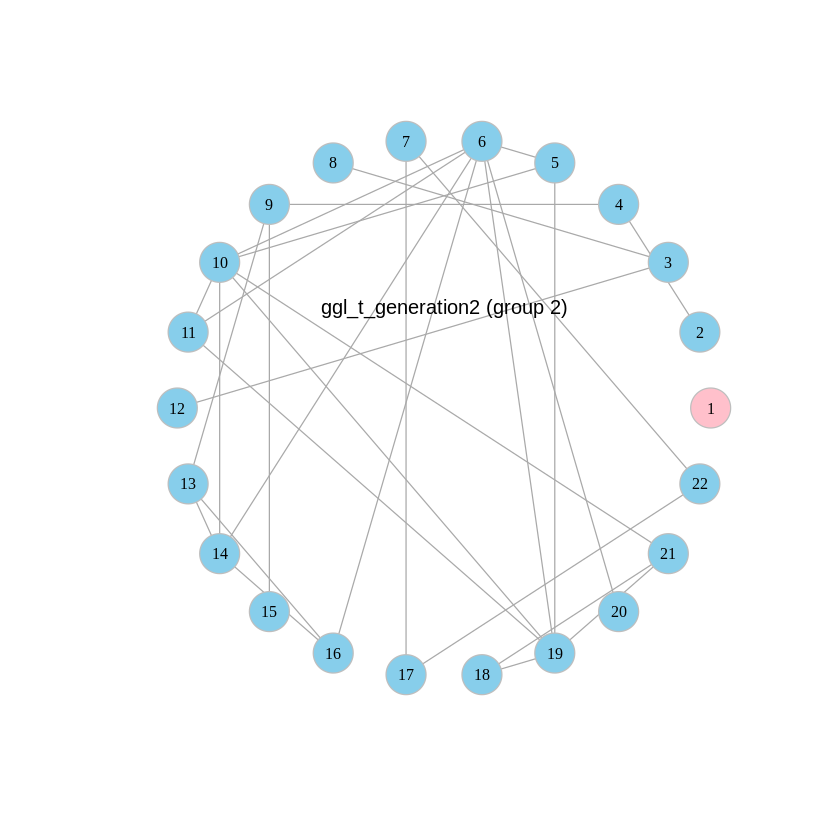

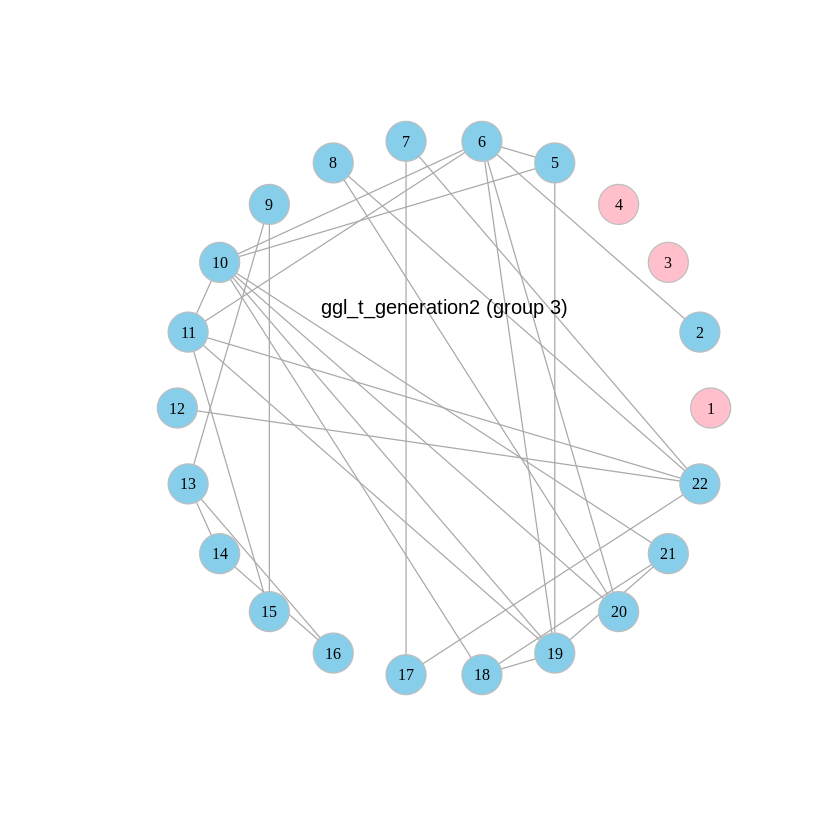

In [31]:
print("##################################################")
print("#    Group Graphical Lasso (tuned parameters)    #")
print("##################################################")
print(paste("lambda_1", lam_1))
print(paste("lambda_2", lam_2))
ggl_t.results=JGL(Y=data,penalty="group",lambda1=lam_1,lambda2=lam_2, return.whole.theta=TRUE) 
print(paste("Average entropy loss:", entropy_loss(ggl_t.results, graph, p, 3)))
print(paste("Average frobenious loss:", frobenious_loss(ggl_t.results, graph, 3)))
print(paste("Average false positive rate:", avg_fprfnr(ggl_t.results, graph, 3)[1]))
print(paste("Average false negative rate:", avg_fprfnr(ggl_t.results, graph, 3)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
show_result(ggl_t.results, graph, 3, method="ggl_t_generation2")

In [32]:
###########################################
#       Parameter Selection               #
#       Akaike Information Criterion      #
#       #perform 2D grid search           #
###########################################
interval_l = 50
lambda.eff <- seq(0.01, 1., len = interval_l)
aic_gl_vec <- rep(NA, length(lambda.eff))
for(i in 1:length(lambda.eff)){
        fit00 <- JGL(Y=data,penalty="group",lambda1=lambda.eff[i],lambda2=0., return.whole.theta=TRUE) 
        aic_gl_vec[i] <- vAIC(data, fit00)        

}

In [33]:
###########################################
#             graphical lasso             #
###########################################

i_idx <- which.min(aic_gl_vec) 

lam_1 <- lambda.eff[i_idx]

print(paste("optimal lambda_1", lam_1))

[1] "optimal lambda_1 0.0908163265306122"


[1] "##################################################"
[1] "#       Graphical Lasso (tuned parameters)      #"
[1] "##################################################"
[1] "lambda_1 0.0908163265306122"
[1] "Average entropy loss: 29.269999680718"
[1] "Average frobenious loss: 0.784151031647631"
[1] "Average false positive rate: 0.321243490808708"
[1] "Average false negative rate: 0.514492753623188"
[1] "##################################################"
[1] "#             Result Visualization               #"
[1] "##################################################"
[1] "visualize estimated graph 1"
[1] "False Negative Rate: 0.391304347826087"
[1] "False Positive Rate: 0.28695652173913"
[1] "Sensitivity 0.0264650283553875"
[1] "visualize estimated graph 2"
[1] "False Negative Rate: 0.652173913043478"
[1] "False Positive Rate: 0.339130434782609"
[1] "Sensitivity 0.0151228733459357"


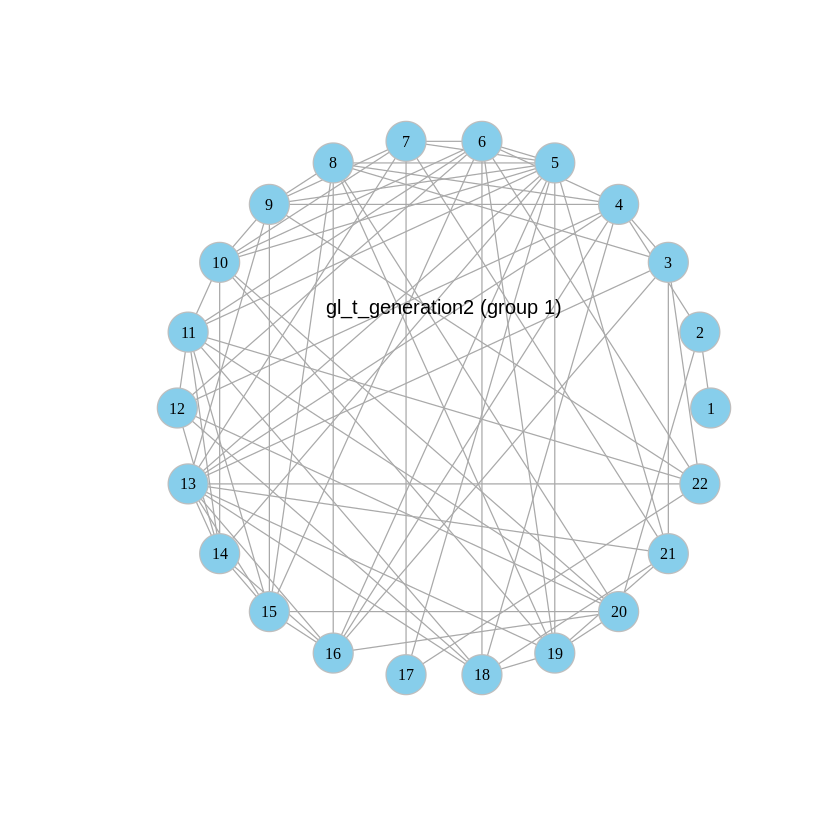

[1] "visualize estimated graph 3"
[1] "False Negative Rate: 0.5"
[1] "False Positive Rate: 0.341991341991342"
[1] "Sensitivity 0.0227272727272727"


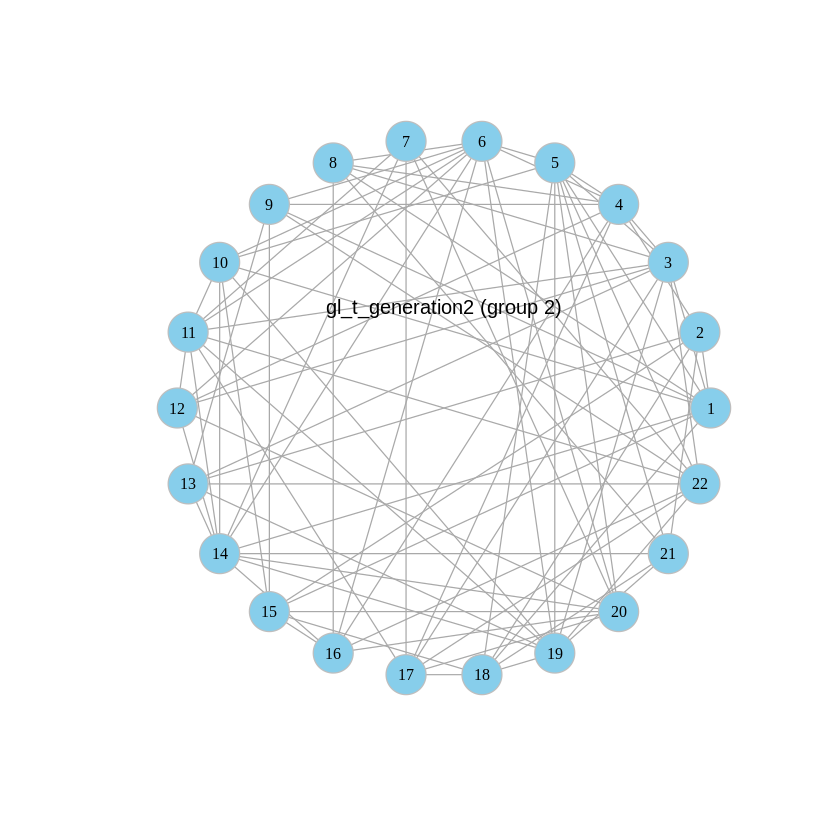

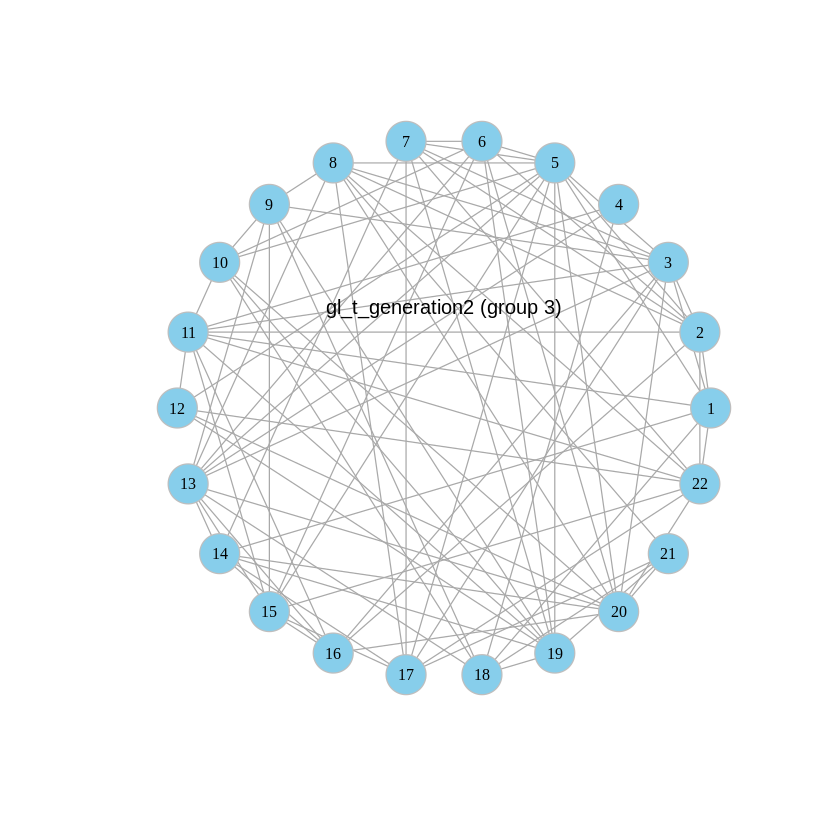

In [35]:
print("##################################################")
print("#       Graphical Lasso (tuned parameters)      #")
print("##################################################")
print(paste("lambda_1", lam_1))
gl_t.results=JGL(Y=data,penalty="group",lambda1=lam_1,lambda2=0., return.whole.theta=TRUE) 
print(paste("Average entropy loss:", entropy_loss(ggl_t.results, graph, p, 3)))
print(paste("Average frobenious loss:", frobenious_loss(gl_t.results, graph, 3)))
print(paste("Average false positive rate:", avg_fprfnr(gl_t.results, graph, 3)[1]))
print(paste("Average false negative rate:", avg_fprfnr(gl_t.results, graph, 3)[2]))
print("##################################################")
print("#             Result Visualization               #")
print("##################################################")
show_result(gl_t.results, graph, 3, method="gl_t_generation2")